#  Прогнозирование заказов такси

Компания такси хочет привлекать больше водителей в период пиковой нагрузки.

В наличии исторические данные о заказах такси в аэропортах. Нужно построить модель для прогноза количества заказов на следующий час.

План работы:
1. Загрузить данные и выполнить их ресемплирование по одному часу
1. Проанализировать данные
1. Обучить разные модели с различными гиперпараметрами
1. Проверить модель на тестовой выборке и сделать выводы

## Подготовка

In [ ]:
!pip install scikit-learn==1.2.2 category_encoders==2.6.1 optuna==3.1.1

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, TargetEncoder
import optuna
import warnings
import joblib

In [ ]:
SEED = abs(hash('Back to the Future')) % (2**32)

In [ ]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

Загружаем датасет

In [ ]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Ресемплируем по одному часу

In [ ]:
df = df.resample('1H').sum()
df[:5]

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

Чтобы проанализировать данные, сделаем декомпозицию временного ряда

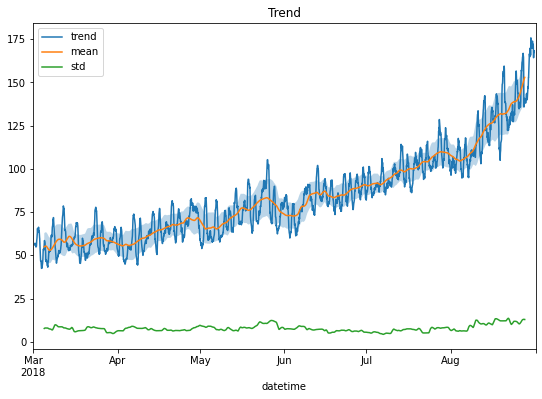

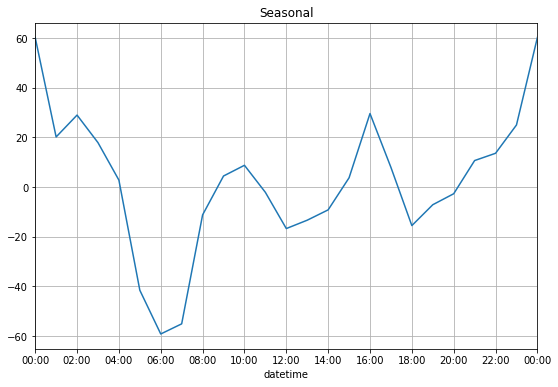

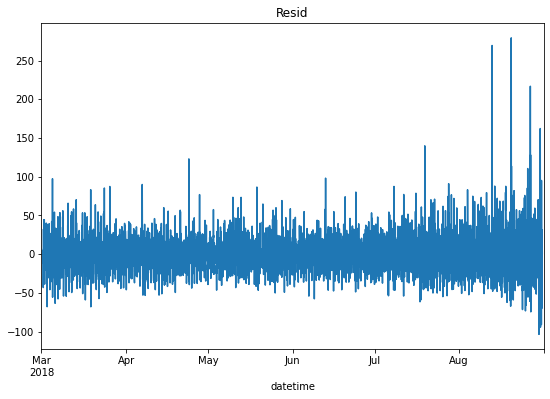

In [ ]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(9, 6))
decomposed.trend.plot(title='Trend')
rol = decomposed.trend.rolling(24*7, center=True)
mean = rol.mean()
std = rol.std()
mean.plot(label='mean')
std.plot(label='std')
plt.fill_between(df.index, mean-std, mean+std, alpha=0.3)
plt.legend()
plt.minorticks_off()
plt.show()

plt.figure(figsize=(9, 6))
decomposed.seasonal['2018-03-01':'2018-03-02 00:00'].plot(title='Seasonal')
d = pd.date_range('2018-03-01', '2018-03-02', freq='2H')
plt.xticks(d, d.strftime('%H:%M'))
plt.grid()
plt.minorticks_off()
plt.show()

plt.figure(figsize=(9, 6))
decomposed.resid.plot(title='Resid')
plt.minorticks_off()
plt.show()

В общем, тренд идёт на увеличение кол-ва заказов. С марта по апрель тренд в среднем почти не меняется. Также заметны небольшие просадки в начале мая, с конца мая по начало июня, в начале августа.

Сезонность - дневная.
Пик заказов такси приходятся на 00:00, 9:00-10:00 и 16:00.
Тогда как меньше всего заказов 5:00-7:00, 12:00 и 18:00.

## Обучение

Добавим несколько функций для более удобной работы

In [ ]:
def make_features(df, lags=0, rols=0):
    df = df.copy()

    df['month'] = df.index.month
    df['dayofweek'] = df.index.dayofweek
    df['day'] = df.index.day
    df['hour'] = df.index.hour

    for i in range(1, lags + 1):
        df[f'lag_{i}'] = df['num_orders'].shift(i)

    if rols > 0:
        df['rolling_mean'] = df['num_orders'].shift(1).rolling(rols).mean()

    return df

In [ ]:
def sample_split(df, test=False, scale=True):
    df = df.dropna()
    x, y = df.drop(['num_orders'], axis=1), df['num_orders']

    xtrain, xvalid, ytrain, yvalid = train_test_split(x, y, test_size=0.2, shuffle=False)
    xvalid, xtest, yvalid, ytest = train_test_split(xvalid, yvalid, test_size=0.5, shuffle=False)

    if scale:
        scaler = StandardScaler()
        xtrain = scaler.fit_transform(xtrain)
        xvalid = scaler.transform(xvalid)
        xtest = scaler.transform(xtest)

    if test:
        return (np.vstack((xtrain, xvalid)),
                np.hstack((ytrain, yvalid)),
                xtest,
                ytest)
    return xtrain, ytrain, xvalid, yvalid

In [ ]:
def rmse(model, lags=0, rols=0, test=False, scale=True, plot=False):
    _df = make_features(df, lags, rols)
    x, y, xt, yt = sample_split(_df, test, scale)
    model.fit(x, y)
    pred = model.predict(xt)

    if plot:
        plt.figure(figsize=(9, 6))
        plt.plot(yt, label='y_true')
        plt.plot(yt.index, pred, label='y_pred')
        d = pd.date_range(yt.index[0], yt.index[-1], freq='2D')
        plt.xticks(d, d.strftime('%d %b'))
        plt.minorticks_on()
        plt.tick_params(which='minor', left=False)
        plt.legend()
        plt.show()

    return mean_squared_error(yt, pred) ** 0.5

In [ ]:
try:
    res = joblib.load('res.pkl')
except FileNotFoundError:
    res = pd.DataFrame(columns=['RMSE', 'trial'])

In [ ]:
def optimize(name, model_fn, n_trials=None, timeout=None):
    if name in res.index:
        value, trial = res.loc[name]
    else:
        sampler = optuna.samplers.TPESampler(seed=SEED)
        study = optuna.create_study(sampler=sampler, direction='minimize')

        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            study.optimize(lambda t: rmse(model_fn(t),
                                          t.suggest_int('lags', 24, 24*7*4, 24),
                                          t.suggest_int('rols', 24, 24*7*4, 24)),
                           n_trials=n_trials,
                           timeout=timeout,
                           show_progress_bar=True)

        trial = study.best_trial
        value = study.best_trial.value

        res.loc[name] = value, trial

    print(f'params: {trial.params}')
    print(f'RMSE: {value:.2f}')

Обучаем модели

In [ ]:
optimize('Linear', lambda _: LinearRegression(), n_trials=75)

params: {'lags': 336, 'rols': 216}
RMSE: 28.77


In [ ]:
optimize('Ridge', lambda _: Ridge(), n_trials=75)

params: {'lags': 336, 'rols': 48}
RMSE: 28.76


In [ ]:
def ridge(trial):
    params = {
        'alpha': trial.suggest_float('alpha', 0.01, 100, log=True),
        'solver': trial.suggest_categorical('solver',
                                            ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'lbfgs']),
        'max_iter': trial.suggest_int('max_iter', 1, 100_000),
    }
    if params['solver'] == 'lbfgs':
        params['positive'] = True
    if params['solver'] not in {'svd', 'cholesky'}:
        params['tol'] = trial.suggest_float('tol', 1e-6, 1, log=True)
    return Ridge(**params)
optimize('Ridge Tuned', ridge, n_trials=75)

params: {'alpha': 1.2227758788645013, 'solver': 'lbfgs', 'max_iter': 70462, 'tol': 0.0001536854564061805, 'lags': 504, 'rols': 120}
RMSE: 28.07


In [ ]:
optimize('Decision Tree',
         lambda _: DecisionTreeRegressor(random_state=SEED),
         n_trials=50)

params: {'lags': 624, 'rols': 72}
RMSE: 38.57


In [ ]:
def decision_tree(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 30),
    }
    return DecisionTreeRegressor(random_state=SEED, **params)
optimize('Decision Tree Tuned', decision_tree, n_trials=50)

params: {'max_depth': 42, 'min_samples_split': 30, 'min_samples_leaf': 23, 'lags': 264, 'rols': 288}
RMSE: 33.01


In [ ]:
optimize('Random Forest',
         lambda _: RandomForestRegressor(random_state=SEED),
         n_trials=25)

params: {'lags': 504, 'rols': 408}
RMSE: 29.77


In [ ]:
def random_forest(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1, 200),
        'max_depth': trial.suggest_int('max_depth', 1, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 15),
    }
    return RandomForestRegressor(random_state=SEED, **params)
optimize('Random Forest Tuned', random_forest, n_trials=25)

params: {'n_estimators': 166, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 8, 'lags': 504, 'rols': 144}
RMSE: 29.68


In [ ]:
optimize('Hist Gradient Boosting',
         lambda _: HistGradientBoostingRegressor(random_state=SEED),
         n_trials=75)

params: {'lags': 504, 'rols': 192}
RMSE: 28.77


In [ ]:
def hist_gradient_boosting(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'max_iter': trial.suggest_int('max_iter', 1, 500),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 300),
        'max_depth': trial.suggest_int('max_depth', 1, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
    }
    return HistGradientBoostingRegressor(random_state=SEED, **params)
optimize('Hist Gradient Boosting Tuned', hist_gradient_boosting, n_trials=75)

params: {'learning_rate': 0.08906286490973916, 'max_iter': 261, 'max_leaf_nodes': 190, 'max_depth': 45, 'min_samples_leaf': 48, 'lags': 288, 'rols': 168}
RMSE: 29.06


In [ ]:
_ = joblib.dump(res, 'res.pkl')

In [ ]:
res['RMSE'].to_frame().style.set_precision(2).highlight_min(color='lightgreen')

,RMSE
Linear,28.77
Ridge,28.76
Ridge Tuned,28.07
Decision Tree,38.57
Decision Tree Tuned,33.01
Random Forest,29.77
Random Forest Tuned,29.68
Hist Gradient Boosting,28.77
Hist Gradient Boosting Tuned,29.06


Самый низкий RMSE получился у **Ridge** с подобраными гиперпараметрами.

## Тестирование

Считаем RMSE лучшей модели на тестовой выборке и визуализируем результаты

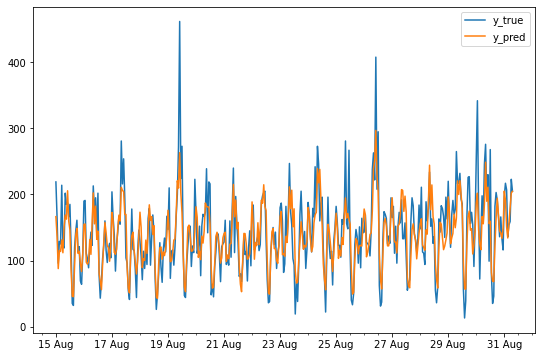

33.71135062893284

In [ ]:
trial = res.loc['Ridge Tuned'].trial
rmse(ridge(trial), trial.params['lags'], trial.params['rols'], test=True, plot=True)

Проверим модель на адекватность, сравнив её с предсказанием средним, медианой и предыдущим значением ряда

In [ ]:
class DummyPrevious():
    def __init__(self, lag_col):
        self.lag_col = lag_col

    def fit(self, x, y=None):
        return self

    def predict(self, x):
        if isinstance(x, pd.DataFrame):
            if isinstance(self.lag_col, int):
                x = x.values
            else:
                return x[self.lag_col]
        return x[:, self.lag_col]

rmse(DummyPrevious('lag_1'), lags=1, test=True, scale=False)

58.856486242815066

Качество полученной модели на 75% лучше dummy модели, предсказывающей предыдущее значение ряда.

Итоги:
- Данные проанализированы и выделены периоды пиковой активности клиентов
- Обучены различные модели для предсказания кол-ва заказов и подобраны гиперпараметры для них
- Проведено сравнение метрики RMSE и выбрана лучшая модель
- Проверено, что итоговая модель удовлетворяет критерию качества на тестовой выборке
- Проверена адекватность модели (сравнение качества с dummy моделями)